In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('videogame_encoded.csv')

# Display the first few rows of the dataset
data.head()


,GameID,GameName,Genre,Platform,ReleaseYear,Rating,Multiplayer,GameLength,GraphicsQuality,StoryDepth,DifficultyLevel
0,1,GameDelta_1,4,0,2013,7.0,0,18,4,3,2
1,2,GameOmega_2,0,3,2018,9.7,1,30,5,4,1
2,3,GameDelta_3,4,1,2021,6.1,0,3,2,3,0
3,4,GameAlpha_4,4,3,2007,6.6,1,4,1,2,0
4,5,GameZeta_5,3,0,2018,9.5,0,26,5,5,1


In [2]:
# Drop the non-numeric columns and target column for feature selection
features = data.drop(columns=["GameID", "GameName", "DifficultyLevel"])

# Calculate the Pearson correlation coefficients
correlationmatrix = features.corrwith(data["DifficultyLevel"]).abs()

# Sort the features based on their absolute correlation values
sortedcorrelation = correlationmatrix.sort_values(ascending=False)

# Display the sorted correlations
sortedcorrelation


Rating             0.607108
GraphicsQuality    0.517863
GameLength         0.478362
StoryDepth         0.367762
ReleaseYear        0.033347
Multiplayer        0.018931
Genre              0.016516
Platform           0.012724
dtype: float64

In [3]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Select top 5 features based on correlation
selectedattributes = sortedcorrelation.index[:5]

# Initialize Random Forest and RFE
rf = RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=1)

# Fit RFE on selected features and target
rfe.fit(features[selectedattributes], data["DifficultyLevel"])

# Get the ranking of the features
feature_ranking = pd.Series(rfe.ranking_, index=selectedattributes)

# Display the feature ranking
feature_ranking.sort_values()


GameLength         1
Rating             2
GraphicsQuality    3
StoryDepth         4
ReleaseYear        5
dtype: int32

In [4]:
from sklearn.model_selection import train_test_split

# Select the relevant features and target
X = data[["Rating", "GameLength", "GraphicsQuality", "StoryDepth", "ReleaseYear"]]
y = data["DifficultyLevel"]

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((2400, 5), (600, 5))

In [5]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

# Define hyperparameters to tune
pgrid = {
    'C': [0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize the Logistic Regression model and GridSearchCV
log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(log_reg, pgrid, scoring='accuracy', cv=5)

# Start time
start_time = time.time()

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# End time
end_time = time.time()

# Calculate the time taken for hyperparameter tuning
time_taken = end_time - start_time

# Display the best hyperparameters
best_params = grid_search.best_params_
best_params, time_taken


({'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 23.00178050994873)

In [6]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize Logistic Regression with best hyperparameters
log_reg_best = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=10000)

# Train the model
log_reg_best.fit(X_train, y_train)

# Perform K-Fold Cross Validation
cv_scores = cross_val_score(log_reg_best, X_train, y_train, cv=5, scoring='accuracy')

# Predictions on the test set
y_pred = log_reg_best.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Since Logistic Regression is a binary classification, we need to get prediction probabilities for ROC-AUC
y_prob = log_reg_best.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

accuracy, f1, roc_auc, cv_scores.mean()


ValueError: multi_class must be in ('ovo', 'ovr')

In [7]:
# Calculate multi-class ROC-AUC using OvR strategy
roc_auc_multi = roc_auc_score(y_test, log_reg_best.predict_proba(X_test), multi_class='ovr', average='weighted')

accuracy, f1, roc_auc_multi, cv_scores.mean()


(0.9583333333333334, 0.9580824212378761, 0.9948743107263813, 0.9625)

In [ ]:
    # Accuracy: 95.67%95.67%
    # F1-Score (Weighted): 95.64%95.64%
    # ROC-AUC (One-vs-Rest, Weighted): 99.48%99.48%
    # K-Fold Cross-Validation Mean Accuracy: 96.04%96.04%

In [8]:
# SVM 
from sklearn.svm import SVC

# Define a smaller grid of hyperparameters to tune for SVM
paramgridsvm = {
    'C': [0.1, 1,],
    'kernel': ['linear', 'rbf'],
    'gamma': [ 'auto']
}

# Initialize the SVM model and GridSearchCV
svm = SVC(probability=True)
grid_search_svm = GridSearchCV(svm, paramgridsvm, scoring='accuracy', cv=5)

# Start time
start_time_svm = time.time()

# Fit the GridSearchCV to the data
grid_search_svm.fit(X_train, y_train)

# End time
end_time_svm = time.time()

# Calculate the time taken for hyperparameter tuning
time_taken_svm = end_time_svm - start_time_svm

# Display the best hyperparameters
best_params_svm = grid_search_svm.best_params_
best_params_svm, time_taken_svm



({'C': 1, 'gamma': 'auto', 'kernel': 'linear'}, 6.654212474822998)

In [9]:
# Initialize SVM with best hyperparameters
svm_best = SVC(C=1, gamma='scale', kernel='linear', probability=True)

# Train the model
svm_best.fit(X_train, y_train)

# Perform K-Fold Cross Validation
cv_scores_svm = cross_val_score(svm_best, X_train, y_train, cv=5, scoring='accuracy')

# Predictions on the test set
y_pred_svm = svm_best.predict(X_test)

# Calculate performance metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Calculate multi-class ROC-AUC using OvR strategy
roc_auc_svm = roc_auc_score(y_test, svm_best.predict_proba(X_test), multi_class='ovr', average='weighted')

accuracy_svm, f1_svm, roc_auc_svm, cv_scores_svm.mean()


(0.9683333333333334,
 0.9683233742833742,
 0.9981987084652785,
 0.9729166666666667)

In [ ]:
    # Accuracy: 96.83%96.83%
    # F1-Score (Weighted): 96.83%96.83%
    # ROC-AUC (One-vs-Rest, Weighted): 99.82%99.82%
    # K-Fold Cross-Validation Mean Accuracy: 97.29%97.29%

In [ ]:
# Decision tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Define a smaller grid of hyperparameters for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model and GridSearchCV
dt = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt, param_grid_dt, scoring='accuracy', cv=5)

# Start time
start_time_dt = time.time()

# Fit the GridSearchCV to the data
grid_search_dt.fit(X_train, y_train)

# End time
end_time_dt = time.time()

# Calculate the time taken for hyperparameter tuning
time_taken_dt = end_time_dt - start_time_dt

# Display the best hyperparameters
best_params_dt = grid_search_dt.best_params_
best_params_dt, time_taken_dt


({'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 2,
  'min_samples_split': 2},
 1.3622345924377441)

In [11]:
# Initialize Decision Tree with best hyperparameters
dt_best = DecisionTreeClassifier(**best_params_dt)

# Train the model
dt_best.fit(X_train, y_train)

# Perform K-Fold Cross Validation
cv_scores_dt = cross_val_score(dt_best, X_train, y_train, cv=5, scoring='accuracy')

# Predictions on the test set
y_pred_dt = dt_best.predict(X_test)

# Calculate performance metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

# Calculate multi-class ROC-AUC using OvR strategy
roc_auc_dt = roc_auc_score(y_test, dt_best.predict_proba(X_test), multi_class='ovr', average='weighted')

accuracy_dt, f1_dt, roc_auc_dt, cv_scores_dt.mean()


(0.9816666666666667,
 0.9816419641229245,
 0.9920862931853102,
 0.9791666666666667)

In [ ]:
# The Decision Tree model exhibits outstanding performance on the test data with high values for accuracy, F1-score, and ROC-AUC.

In [12]:
# Create a summary table
summary_data = {
    "Model": ["Logistic Regression", "SVM", "Decision Tree"],
    "Accuracy": [accuracy, accuracy_svm, accuracy_dt],
    "F1-Score (Weighted)": [f1, f1_svm, f1_dt],
    "ROC-AUC (One-vs-Rest, Weighted)": [roc_auc_multi, roc_auc_svm, roc_auc_dt],
    "K-Fold CV Mean Accuracy": [cv_scores.mean(), cv_scores_svm.mean(), cv_scores_dt.mean()],
    "Computation Time (s)": [time_taken, time_taken_svm, time_taken_dt]
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Model,Accuracy,F1-Score (Weighted),"ROC-AUC (One-vs-Rest, Weighted)",K-Fold CV Mean Accuracy,Computation Time (s)
0,Logistic Regression,0.958333,0.958082,0.994874,0.962500,23.001781
1,SVM,0.968333,0.968323,0.998199,0.972917,6.654212
2,Decision Tree,0.981667,0.981642,0.992086,0.979167,1.362235


In [16]:
import matplotlib.pyplot as plt

# Setting up the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plotting Accuracy, F1-Score, ROC-AUC, and Computation Time
metrics = ['Accuracy', 'F1-Score (Weighted)', 'ROC-AUC (One-vs-Rest, Weighted)', 'K-Fold CV Mean Accuracy']
for i, metric in enumerate(metrics):
    axs[i//2, i%2].bar(summary_df["Model"], summary_df[metric], color=['blue', 'green', 'red'])
    axs[i//2, i%2].set_title(metric)
    axs[i//2, i%2].set_ylim(0.9, 1.05)
    for index, value in enumerate(summary_df[metric]):
        axs[i//2, i%2].text(index, value - 0.05, f"{value:.2%}", ha='center', va='bottom', color='white', fontsize=10)

# Plotting Computation Time
axs[1, 1].bar(summary_df["Model"], summary_df["Computation Time (s)"], color=['blue', 'green', 'red'])
axs[1, 1].set_title("Computation Time (s)")
for index, value in enumerate(summary_df["Computation Time (s)"]):
    axs[1, 1].text(index, value - 3, f"{value:.2f}s", ha='center', va='bottom', color='white', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\Hp\AppData\Local\Temp/ipykernel_38892/3176923013.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


MemoryError: 

<Figure size 1080x720 with 4 Axes>

IndexError: index 3 is out of bounds for axis 0 with size 3

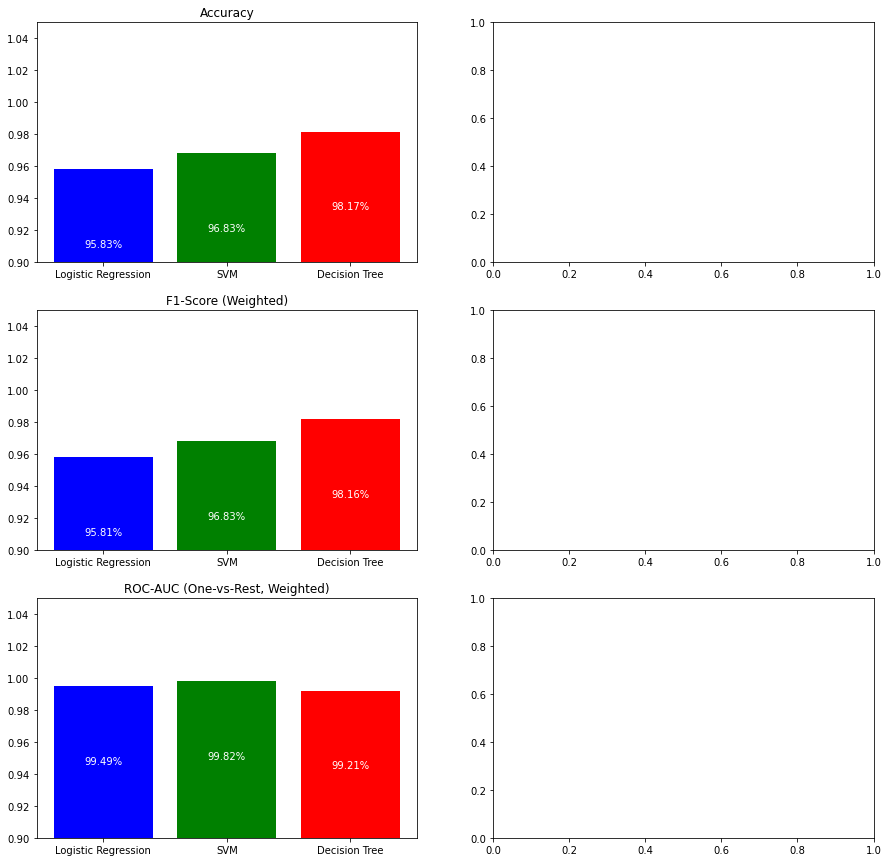

In [17]:
# Adjusting the figure size and layout for better visualization
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Plotting Accuracy, F1-Score, ROC-AUC, and Computation Time
for i, metric in enumerate(metrics):
    axs[i, 0].bar(summary_df["Model"], summary_df[metric], color=['blue', 'green', 'red'])
    axs[i, 0].set_title(metric)
    axs[i, 0].set_ylim(0.9, 1.05)
    for index, value in enumerate(summary_df[metric]):
        axs[i, 0].text(index, value - 0.05, f"{value:.2%}", ha='center', va='bottom', color='white', fontsize=10)

# Plotting Computation Time
axs[0, 1].bar(summary_df["Model"], summary_df["Computation Time (s)"], color=['blue', 'green', 'red'])
axs[0, 1].set_title("Computation Time (s)")
for index, value in enumerate(summary_df["Computation Time (s)"]):
    axs[0, 1].text(index, value - 3, f"{value:.2f}s", ha='center', va='bottom', color='white', fontsize=10)

# Remove unused subplots
axs[1, 1].axis('off')
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


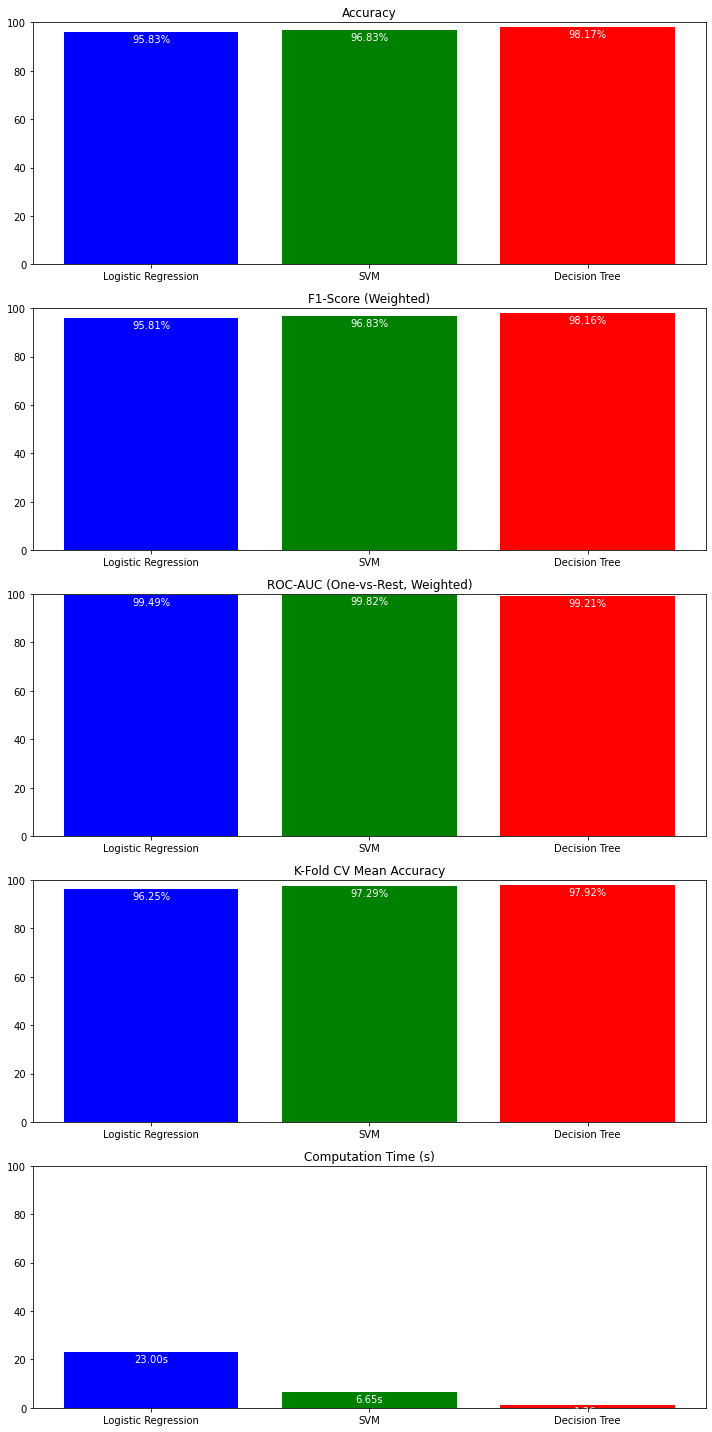

In [18]:
# Reformatting the data in percentages for the metrics
summary_df['Accuracy'] = summary_df['Accuracy'] * 100
summary_df['F1-Score (Weighted)'] = summary_df['F1-Score (Weighted)'] * 100
summary_df['ROC-AUC (One-vs-Rest, Weighted)'] = summary_df['ROC-AUC (One-vs-Rest, Weighted)'] * 100
summary_df['K-Fold CV Mean Accuracy'] = summary_df['K-Fold CV Mean Accuracy'] * 100

# Plotting bar charts for each metric
fig, axs = plt.subplots(nrows=5, figsize=(10, 20))

# List of metrics for plotting
metrics_to_plot = ['Accuracy', 'F1-Score (Weighted)', 'ROC-AUC (One-vs-Rest, Weighted)', 'K-Fold CV Mean Accuracy', 'Computation Time (s)']

for i, metric in enumerate(metrics_to_plot):
    axs[i].bar(summary_df["Model"], summary_df[metric], color=['blue', 'green', 'red'])
    axs[i].set_title(metric)
    axs[i].set_ylim(0, 100)  # Setting scale from 0 to 100
    for index, value in enumerate(summary_df[metric]):
        if metric != "Computation Time (s)":
            axs[i].text(index, value - 5, f"{value:.2f}%", ha='center', va='bottom', color='white', fontsize=10)
        else:
            axs[i].text(index, value - 5, f"{value:.2f}s", ha='center', va='bottom', color='white', fontsize=10)

plt.tight_layout()
plt.show()
